In [680]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [681]:
pp_train = pd.read_csv("pp_train.csv")
pp_test = pd.read_csv("pp_test.csv")

pp_class = pp_train.copy()
pp_test_class = pp_test.copy()

### tolgo record con outliers

In [682]:
pp_class = pp_class[pp_class["outlier_no_type"] != True]
pp_test_class = pp_test_class[pp_test_class["outlier_no_type"] != True]

### Preprocessing delle variabili

Elimino righe videogame

In [683]:
pp_class = pp_class[pp_class['titleType'] != 'videoGame']
pp_class[['originalTitle', 'titleType']].head(15)

pp_test_class = pp_test_class[pp_test_class['titleType'] != 'videoGame']

Mapping variabile target

In [684]:

y = np.array(pp_class['titleType'])  # Il target originale


# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(pp_class['titleType'].unique())}

#aggiungo una nuova colonna
pp_class['titleType_encoded'] = pp_class['titleType'].map(y_map)
pp_test_class["titleType_encoded"] = pp_test_class['titleType'].map(y_map)

y_map # Per vedere la mappatura delle categorie

{'tvEpisode': 0,
 'movie': 1,
 'tvSeries': 2,
 'tvMiniSeries': 3,
 'short': 4,
 'tvMovie': 5,
 'tvSpecial': 6,
 'video': 7}

##### info variabili

In [685]:
pp_class.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'numRegions', 'userReviewsTotal', 'is_Documentary',
       'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation', 'is_from_Oceania',
       'is_from_North America', 'is_from_South America', 'is_from_Asia',
       'is_from_Africa', 'is_from_Europe', 'countryOfOrigin',
       'countryOfOrigin_freq_enc', 'countryOfOrigin_NA', 'countryOfOrigin_AF',
       'countryOfOrigin_AS', 'countryOfOrigin_EU',

gestione country of origin  -> già sul train -> codice su modifiche_test

Conversione CanHaveEpisodes in binaria 0/1 (is Adult già binaria)

In [686]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)
pp_test_class['canHaveEpisodes'] = pp_test_class['canHaveEpisodes'].astype(int)

Rimuoviamo titleType dato che è già stata mappata + originaltitle e runtimeminutes non filled

In [687]:
column2drop = ['originalTitle', 'runtimeMinutes', 'titleType']
pp_class.drop(column2drop, axis=1, inplace=True)
pp_test_class.drop(column2drop, axis=1, inplace=True)

END YEAR-> tolto finchè non capiamo come gestirlo -> ora commentato nella scelta features

In [688]:
# Riempi i valori mancanti di 'endYear' con quelli di 'startYear' 
# -> DA VEDERE SE GIà SOSTITUITO

#OPPURE RIMUOVI
#pp_class= pp_class.drop(["endYear"], axis=1)
##pp_test_class= pp_class.drop(["endYear"], axis=1)

BINARIZZAZIONE -> TOTALmEDIA E TOTALnOM

In [689]:

# #1 binarizzazione (0 / >0) per le variabili con tanti zeri (consigliato per NB)

# pp_class['totalNominations_bin'] = (pp_class['totalNominations'] > 0).astype(int)
# pp_class['totalMedia_bin'] = (pp_class['totalMedia'] > 0).astype(int)

# pp_test_class['totalNominations_bin'] = (pp_test_class['totalNominations'] > 0).astype(int)
# pp_test_class['totalMedia_bin'] = (pp_test_class['totalMedia'] > 0).astype(int)


In [690]:
#TOTALNOMINATIONS 
bins = [-1, 0, 2, 10, pp_class['totalNominations'].max()]
labels = ['ZeroNom', 'LowNom', 'MediumNom', 'VeryHighNom']
pp_class['totalNominations_bin'] = pd.cut(pp_class['totalNominations'], 
                                bins=bins, 
                                labels=labels)

bins = [-1, 0, 2, 10, pp_test_class['totalNominations'].max()]
labels = ['ZeroNom', 'LowNom', 'MediumNom', 'VeryHighNom']
pp_test_class['totalNominations_bin'] = pd.cut(pp_test_class['totalNominations'], 
                                bins=bins, 
                                labels=labels)

#TOTALMEDIA
bins = [-1, 0, 1, 8, 50, pp_class['totalMedia'].max()]
labels = ['ZeroMedia', 'LowMedia', 'MediumMedia', 'HighMedia', 'VeryHighMedia']
pp_class['totalMedia_bin'] = pd.cut(pp_class['totalMedia'], bins=bins, labels=labels)


bins = [-1, 0, 1, 8, 50, pp_test_class['totalMedia'].max()]
labels = ['ZeroMedia', 'LowMedia', 'MediumMedia', 'HighMedia', 'VeryHighMedia']
pp_test_class['totalMedia_bin'] = pd.cut(pp_test_class['totalMedia'], bins=bins, labels=labels)


In [691]:
# Calcola statistiche descrittive per la colonna 'runtimeMinutes_notitletype' di pp_test

# Se vuoi anche per il train:
print("\nStatistiche runtimeMinutes_notitletype (train):")
print(pp_class['runtimeMinutes_notitletype'].describe(percentiles=[.25, .5, .75, .9, .95, .99]))


Statistiche runtimeMinutes_notitletype (train):
count    15783.000000
mean        58.466071
std         33.203534
min          1.000000
25%         30.000000
50%         60.000000
75%         87.000000
90%         98.000000
95%        109.000000
99%        136.000000
max        153.000000
Name: runtimeMinutes_notitletype, dtype: float64


In [692]:
#train

#FILL_RUNTIMEMINS_BRUNO 
bins = [0, 30, 60, 90,  float('inf') ]
labels = ['0_VeryLowRuntime', '1_LowRuntime', '2_MediumRuntime', '3_HighRuntime']
pp_class['runtime_bin'] = pd.cut(pp_class['runtimeMinutes_notitletype'], bins=bins, labels=labels)

#RATING 
bins = [-1, 3, 6, 7, 8, pp_class['rating'].max()]
labels = ['0_VeryLowRating', '1_LowRating', '2_MediumRating', '3_HighRating', "4_VeryHighRating"]
pp_class['rating_bin'] = pd.cut(pp_class['rating'], bins=bins, labels=labels)

#NUMVOTES 
labels = ['0_VeryLowVotes', '1_LowVotes', '2_MediumVotes', '3_HighVotes', '4_VeryHighVotes']
bins = [4, 15, 50, 150, 1000, float('inf')]  # include il min=5 e max=1.071.372
pp_class['numVotes_bin'] = pd.cut(pp_class['numVotes'], bins=bins, labels=labels, include_lowest=True)

#STARTYEAR
bins =[
    1878,  # Cinema delle origini e muto
    1930,  # Cinema sonoro classico e radio
    1955,  # TV B/N e colore, cinema widescreen
    1980,  # Video domestico e media transazionali
    2000,  # DVD, internet e mobile
    2015,  # Streaming integrato e nuovi media
    pp_class['startYear'].max()] #era corrente
labels = ['0_pre-1930', '1_1930-1954', '2_1955-1979', '3_1980-1999', '4_2000-2019', '5_post-2020']
pp_class['startYear_bin'] = pd.cut(pp_class['startYear'], bins=bins, labels=labels, include_lowest=True)

#TOTALCREDITS NON LOG-TRANSFORMED
labels = ['0_VeryLowCredits', '1_LowCredits', '2_MediumCredits', '3_HighCredits']
bins = [-1, 15, 35, 65, float('inf')]
pp_class['totalCredits_bin'] = pd.cut(pp_class['totalCredits'], bins=bins, labels=labels, include_lowest=True)

#CRITICREVIEWS NON LOG-TRANSFORMED
labels = [
    '0_NoCriticReviews',
    '1_FewCriticReviews',
    '2_ModerateCriticReviews',
    '3_ManyCriticReviews',
    '4_VeryHighCriticReviews',
    '5_ExtensiveCriticReviews'
]
bins = [-1, 0, 1, 5, 20, 45, float('inf')]
pp_class['criticReviewsTotal_bin'] = pd.cut(pp_class['criticReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

#NUMREGIONS NON LOG-TRANSFORMED
labels = ['0_FewRegions', '1_ModerateRegions', '2_ManyRegions']
bins = [0, 1, 8, float('inf')]
pp_class['numRegions_bin'] = pd.cut(pp_class['numRegions'], bins=bins, labels=labels, include_lowest=True)

#USERREVIEWSTOTAL NON LOG-TRANSFORMED
labels = ['0_NoUserReviews', '1_FewUserReviews', '2_ManyUserReviews', '3_VeryManyUserReviews']
bins = [-1, 0, 3, 30, float('inf')]
pp_class['userReviewsTotal_bin'] = pd.cut(pp_class['userReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

## COUNTRY OF ORIGIN freq-> 
bins = [-0.01, 0.03, 0.3, 1.0]
labels = ['0_LowFreqCountries', '1_MediumFreqCountries', '2_HighFreqCountries']
pp_class["country_freq_bin"] = pd.cut( pp_class["countryOfOrigin_freq_enc"], bins=bins,  labels=labels)

## COUNTRY OF ORIGIN CONTINENTI -> 
def discretize_continent_count(df, col_name, cont):
    new_col = f'{cont }_bin'
    
    def label(value):
        if value == 0:
            return f'0_not_{cont}'
       # elif value == 1:
        #    return f'one_{cont}'
        else:
            return f'1_is_{cont}'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
discretize_continent_count(pp_class, "countryOfOrigin_NA", "from_NorthAmerica")
discretize_continent_count(pp_class, "countryOfOrigin_EU", "from_Europe")
discretize_continent_count(pp_class, "countryOfOrigin_SA", "from_SouthAmerica")
discretize_continent_count(pp_class, "countryOfOrigin_AS", "from_Asia")
discretize_continent_count(pp_class, "countryOfOrigin_OC", "from_Oceania")
discretize_continent_count(pp_class, "countryOfOrigin_AF", "from_Africa")
discretize_continent_count(pp_class, "countryOfOrigin_UNK", "from_Unknown")

# BINARIZZAZIONE 
def genre_column(df, col_name, genre):
    new_col = f'{genre}_bin'
    
    def label(value):
        if value == 0:
            return f'0_not_{genre}_genre'
       # elif value == 1:
        #    return f'one_{genre}'
        else:
            return f'1_is_{genre}_genre'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
genre_column(pp_class, "is_Documentary", "documentary")
genre_column(pp_class, "is_History", "history")
genre_column(pp_class, "is_Adventure", "adventure")
genre_column(pp_class, "is_Thriller", "thriller")
genre_column(pp_class, "is_Game-Show", "game-show")
genre_column(pp_class, "is_Comedy", "comedy")
genre_column(pp_class, "is_Sci-Fi", "sci-fi")
genre_column(pp_class, "is_Romance", "romance")
genre_column(pp_class, "is_Biography", "biography")
genre_column(pp_class, "is_Musical", "musical")
genre_column(pp_class, "is_Western", "western")
genre_column(pp_class, "is_Music", "music")
genre_column(pp_class, "is_Film-Noir", "film-noir")
genre_column(pp_class, "is_Adult", "adult")
genre_column(pp_class, "is_Reality-TV", "reality-tv")
genre_column(pp_class, "is_News", "news")
genre_column(pp_class, "is_Action", "action")
genre_column(pp_class, "is_Crime", "crime")
genre_column(pp_class, "is_Short", "short")
genre_column(pp_class, "is_Fantasy", "fantasy")
genre_column(pp_class, "is_Family", "family")
genre_column(pp_class, "is_Mystery", "mystery")
genre_column(pp_class, "is_Talk-Show", "talk-show")
genre_column(pp_class, "is_Drama", "drama")
genre_column(pp_class, "is_Sport", "sport")
genre_column(pp_class, "is_War", "war")
genre_column(pp_class, "is_Horror", "horror")
genre_column(pp_class, "is_Animation", "animation")



In [693]:
#test

#FILL_RUNTIMEMINS_BRUNO 
bins = [0, 30, 60, 90,  pp_test_class['runtimeMinutes_notitletype'].max()]
labels = ['0_VeryLowRuntime', '1_LowRuntime', '2_MediumRuntime', '3_HighRuntime']
pp_test_class['runtime_bin'] = pd.cut(pp_test_class['runtimeMinutes_notitletype'], bins=bins, labels=labels)

#RATING 
bins = [-1, 3, 6, 7, 8, pp_test_class['rating'].max()]
labels = ['0_VeryLowRating', '1_LowRating', '2_MediumRating', '3_HighRating', "4_VeryHighRating"]
pp_test_class['rating_bin'] = pd.cut(pp_test_class['rating'], bins=bins, labels=labels)

#NUMVOTES 
labels = ['0_VeryLowVotes', '1_LowVotes', '2_MediumVotes', '3_HighVotes', '4_VeryHighVotes']
bins = [4, 15, 50, 150, 1000, float('inf')]  # include il min=5 e max=1.071.372
pp_test_class['numVotes_bin'] = pd.cut(pp_test_class['numVotes'], bins=bins, labels=labels, include_lowest=True)

#STARTYEAR
bins =[
    1877,  # Cinema delle origini e muto
    1930,  # Cinema sonoro classico e radio
    1955,  # TV B/N e colore, cinema widescreen
    1980,  # Video domestico e media transazionali
    2000,  # DVD, internet e mobile
    2015,  # Streaming integrato e nuovi media
    pp_test_class['startYear'].max()] #era corrente
labels = ['0_pre-1930', '1_1930-1954', '2_1955-1979', '3_1980-1999', '4_2000-2019', '5_post-2020']
pp_test_class['startYear_bin'] = pd.cut(pp_test_class['startYear'], bins=bins, labels=labels, include_lowest=True)

#TOTALCREDITS NON LOG-TRANSFORMED
labels = ['0_VeryLowCredits', '1_LowCredits', '2_MediumCredits', '3_HighCredits']
bins = [-1, 15, 35, 65, float('inf')]

pp_test_class['totalCredits_bin'] = pd.cut(pp_test_class['totalCredits'], bins=bins, labels=labels, include_lowest=True)

#CRITICREVIEWS NON LOG-TRANSFORMED
labels = [
    '0_NoCriticReviews',
    '1_FewCriticReviews',
    '2_ModerateCriticReviews',
    '3_ManyCriticReviews',
    '4_VeryHighCriticReviews',
    '5_ExtensiveCriticReviews'
]
bins = [-1, 0, 1, 5, 20, 45, float('inf')]
pp_test_class['criticReviewsTotal_bin'] = pd.cut(pp_test_class['criticReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

#NUMREGIONS NON LOG-TRANSFORMED
labels = ['0_FewRegions', '1_ModerateRegions', '2_ManyRegions']
bins = [0, 1, 8, float('inf')]
pp_test_class['numRegions_bin'] = pd.cut(pp_test_class['numRegions'], bins=bins, labels=labels, include_lowest=True)

#USERREVIEWSTOTAL NON LOG-TRANSFORMED
labels = ['0_NoUserReviews', '1_FewUserReviews', '2_ManyUserReviews', '3_VeryManyUserReviews']
bins = [-1, 0, 3, 30, float('inf')]

pp_test_class['userReviewsTotal_bin'] = pd.cut(pp_test_class['userReviewsTotal'], bins=bins, labels=labels, include_lowest=True)

## COUNTRY OF ORIGIN FREQ ENC 
bins = [-0.01, 0.03, 0.3, 1.0]
labels = ['0_LowFreqCountries', '1_MediumFreqCountries', '2_HighFreqCountries']

pp_test_class["country_freq_bin"] = pd.cut( pp_test_class["countryOfOrigin_freq_enc"], bins=bins,  labels=labels)

## COUNTRY OF ORIGIN CONTINENTI -> 
def discretize_continent_count(df, col_name, cont):
    new_col = f'{cont }_bin'
    
    def label(value):
        if value == 0:
            return f'0_not_{cont}'
       # elif value == 1:
        #    return f'one_{cont}'
        else:
            return f'1_is_{cont}'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
discretize_continent_count(pp_test_class, "countryOfOrigin_NA", "from_NorthAmerica")
discretize_continent_count(pp_test_class, "countryOfOrigin_EU", "from_Europe")
discretize_continent_count(pp_test_class, "countryOfOrigin_SA", "from_SouthAmerica")
discretize_continent_count(pp_test_class, "countryOfOrigin_AS", "from_Asia")
discretize_continent_count(pp_test_class, "countryOfOrigin_OC", "from_Oceania")
discretize_continent_count(pp_test_class, "countryOfOrigin_AF", "from_Africa")
discretize_continent_count(pp_test_class, "countryOfOrigin_UNK", "from_Unknown")



# BINARIZZAZIONE 
def genre_column(df, col_name, genre):
    new_col = f'{genre}_bin'
    
    def label(value):
        if value == 0:
            return f'0_not_{genre}_genre'
       # elif value == 1:
        #    return f'one_{genre}'
        else:
            return f'1_is_{genre}_genre'
    
    df[new_col] = df[col_name].apply(label)

# applico funzione
genre_column(pp_test_class, "is_Documentary", "documentary")
genre_column(pp_test_class, "is_History", "history")
genre_column(pp_test_class, "is_Adventure", "adventure")
genre_column(pp_test_class, "is_Thriller", "thriller")
genre_column(pp_test_class, "is_Game-Show", "game-show")
genre_column(pp_test_class, "is_Comedy", "comedy")
genre_column(pp_test_class, "is_Sci-Fi", "sci-fi")
genre_column(pp_test_class, "is_Romance", "romance")
genre_column(pp_test_class, "is_Biography", "biography")
genre_column(pp_test_class, "is_Musical", "musical")
genre_column(pp_test_class, "is_Western", "western")
genre_column(pp_test_class, "is_Music", "music")
genre_column(pp_test_class, "is_Film-Noir", "film-noir")
genre_column(pp_test_class, "is_Adult", "adult")
genre_column(pp_test_class, "is_Reality-TV", "reality-tv")
genre_column(pp_test_class, "is_News", "news")
genre_column(pp_test_class, "is_Action", "action")
genre_column(pp_test_class, "is_Crime", "crime")
genre_column(pp_test_class, "is_Short", "short")
genre_column(pp_test_class, "is_Fantasy", "fantasy")
genre_column(pp_test_class, "is_Family", "family")
genre_column(pp_test_class, "is_Mystery", "mystery")
genre_column(pp_test_class, "is_Talk-Show", "talk-show")
genre_column(pp_test_class, "is_Drama", "drama")
genre_column(pp_test_class, "is_Sport", "sport")
genre_column(pp_test_class, "is_War", "war")
genre_column(pp_test_class, "is_Horror", "horror")
genre_column(pp_test_class, "is_Animation", "animation")




In [694]:
pp_class.head()

,rating,startYear,endYear,awardWins,numVotes,totalImages,totalVideos,totalCredits,criticReviewsTotal,awardNominationsExcludeWins,...,short_bin,fantasy_bin,family_bin,mystery_bin,talk-show_bin,drama_bin,sport_bin,war_bin,horror_bin,animation_bin
0,8,1995,1995.0,0.0,779,1,0,21,1,0,...,0_not_short_genre,0_not_fantasy_genre,0_not_family_genre,0_not_mystery_genre,0_not_talk-show_genre,0_not_drama_genre,0_not_sport_genre,0_not_war_genre,0_not_horror_genre,1_is_animation_genre
1,6,1992,1992.0,0.0,38,1,0,24,0,0,...,0_not_short_genre,0_not_fantasy_genre,0_not_family_genre,0_not_mystery_genre,0_not_talk-show_genre,0_not_drama_genre,0_not_sport_genre,0_not_war_genre,0_not_horror_genre,0_not_animation_genre
2,6,2021,NaN,0.0,15,22,0,56,0,0,...,0_not_short_genre,0_not_fantasy_genre,0_not_family_genre,0_not_mystery_genre,0_not_talk-show_genre,0_not_drama_genre,0_not_sport_genre,0_not_war_genre,0_not_horror_genre,0_not_animation_genre
3,8,2020,2020.0,1.0,15718,347,2,47,4,1,...,0_not_short_genre,0_not_fantasy_genre,0_not_family_genre,0_not_mystery_genre,0_not_talk-show_genre,1_is_drama_genre,0_not_sport_genre,0_not_war_genre,0_not_horror_genre,0_not_animation_genre
5,8,1995,1995.0,0.0,96,5,0,110,0,0,...,0_not_short_genre,0_not_fantasy_genre,0_not_family_genre,0_not_mystery_genre,0_not_talk-show_genre,1_is_drama_genre,0_not_sport_genre,0_not_war_genre,0_not_horror_genre,0_not_animation_genre


### !! DIVERSO DA GAIA (1,5,6,9)--> Filtra dataset su classi meno rappresentate ->"tvMovie": 7, "tvSpecial":8, "tvShort":9

In [695]:
#pp_class = pp_class[~pp_class['titleType_encoded'].isin([7,8, 9])] # isin([1,5,6,9])]
## pp_test_class = pp_test_class[~pp_test_class['titleType_encoded'].isin([7,8, 9])]

Encoding di titletype per multiclass classification task

In [696]:
# Extract target (y)
y_train = pp_class["titleType_encoded"].values  # Convert directly to NumPy
y_test = pp_test_class["titleType_encoded"].values  # Convert directly to NumPy

####  creazione array di valori -> da cui scegliere feature da usare

In [697]:
X_train = pp_class[[
       'rating_bin',
       'startYear_bin', 
       'totalCredits_bin',
       'criticReviewsTotal_bin', 
       'canHaveEpisodes', 
       'userReviewsTotal_bin',  
       'country_freq_bin', ########  forsecrea problemi
       'from_NorthAmerica_bin', 
       'totalMedia_bin',
       'runtime_bin',
       #'numVotes_bin',
       'numRegions_bin', 
       #'from_Europe_bin', 'from_SouthAmerica_bin', 'from_Asia_bin',  'from_Oceania_bin', 'from_Africa_bin', 'from_Unknown_bin',
       #'totalNominations_bin',
       'documentary_bin', 'history_bin', 'adventure_bin', 'thriller_bin',
       'game-show_bin', 'comedy_bin', 'sci-fi_bin', 'romance_bin',
       'biography_bin', 'musical_bin', 'western_bin', 'music_bin',
       'film-noir_bin', 'adult_bin', 'reality-tv_bin', 'news_bin',
       'action_bin', 'crime_bin', 'short_bin', 'fantasy_bin', 'family_bin',
       'mystery_bin', 'talk-show_bin', 'drama_bin', 'sport_bin', 'war_bin',
       'horror_bin', 'animation_bin'
       ]].values

X_test = pp_test_class[[ 
       'rating_bin',
       'startYear_bin', 
       'totalCredits_bin',
       'criticReviewsTotal_bin', 
       'canHaveEpisodes', 
       'userReviewsTotal_bin',  
       'country_freq_bin', ########  forsecrea problemi
       'from_NorthAmerica_bin', 
       'totalMedia_bin',
       'runtime_bin',
       #'numVotes_bin',
       'numRegions_bin', 
       #'from_Europe_bin', 'from_SouthAmerica_bin', 'from_Asia_bin',  'from_Oceania_bin', 'from_Africa_bin', 'from_Unknown_bin',
       #'totalNominations_bin',
       'documentary_bin', 'history_bin', 'adventure_bin', 'thriller_bin',
       'game-show_bin', 'comedy_bin', 'sci-fi_bin', 'romance_bin',
       'biography_bin', 'musical_bin', 'western_bin', 'music_bin',
       'film-noir_bin', 'adult_bin', 'reality-tv_bin', 'news_bin',
       'action_bin', 'crime_bin', 'short_bin', 'fantasy_bin', 'family_bin',
       'mystery_bin', 'talk-show_bin', 'drama_bin', 'sport_bin', 'war_bin',
       'horror_bin', 'animation_bin'
 
       ]].values

In [698]:
# valutare country
        # 'from_NorthAmerica_bin','from_Europe_bin' , 'from_SouthAmerica_bin', 
        # 'from_Asia_bin', 'from_Oceania_bin', 'from_Africa_bin', 
        # 'from_Unknown_bin'

#valutare generi
# 'documentary_bin', 'history_bin', 'adventure_bin', 'thriller_bin',
#        'game-show_bin', 'comedy_bin', 'sci-fi_bin', 'romance_bin',
#        'biography_bin', 'musical_bin', 'western_bin', 'music_bin',
#        'film-noir_bin', 'adult_bin', 'reality-tv_bin', 'news_bin',
#        'action_bin', 'crime_bin', 'short_bin', 'fantasy_bin', 'family_bin',
#        'mystery_bin', 'talk-show_bin', 'drama_bin', 'sport_bin', 'war_bin',
#        'horror_bin', 'animation_bin'

In [699]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train= encoder.fit_transform(X_train)  # dove X ha solo colonne categoriche (incluse le binned)
X_test= encoder.transform(X_test)  # dove X ha solo colonne categoriche (incluse le binned)


### Splitting in validation 
##### -> penso su y_train (array valori multilabeled)

In [700]:
X_train2, X_val, y_train2, y_val = train_test_split(
     X_train, y_train, test_size=0.2, random_state=32
)

In [701]:
print(X_train2.shape, X_val.shape, X_train.shape
      , X_test.shape
      )

(12626, 39) (3157, 39) (15783, 39) (5246, 39)


In [702]:
# CATEGORICAL
X_train2_tr = X_train2
X_val_tr = X_val

X_train_tr = X_train
X_test_tr = X_test

## NAIVE BAYES

In [703]:
#clf = GaussianNB()
#clf = ComplementNB(alpha=1.0) -> non va perchè ci sono valori negativi
clf = CategoricalNB()

In [704]:
clf.fit(X_train2_tr, y_train2)

CategoricalNB()

Predicting on validation set

In [705]:
y_pred = clf.predict(X_val_tr)
y_pred

array([2, 2, 0, ..., 0, 7, 7], dtype=int64)

In [706]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3157
3157


In [707]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7}


In [708]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.8137472283813747

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       952
           1       0.81      0.87      0.84      1072
           2       0.91      0.98      0.94       268
           3       0.17      0.04      0.06        26
           4       0.90      0.94      0.92       470
           5       0.25      0.15      0.19       179
           6       0.26      0.26      0.26        31
           7       0.57      0.45      0.50       159

    accuracy                           0.81      3157
   macro avg       0.59      0.57      0.57      3157
weighted avg       0.79      0.81      0.80      3157



In [709]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[1.59836019e-05, 8.70501706e-05, 7.18253854e-01, ...,
        5.58839801e-05, 5.21426440e-06, 4.67382918e-07],
       [9.63684257e-05, 3.49615541e-05, 9.38905445e-01, ...,
        3.32235048e-04, 1.50495872e-03, 9.56995396e-05],
       [9.83913737e-01, 2.08318164e-03, 6.08530732e-04, ...,
        3.28495743e-03, 8.47222925e-03, 1.58493969e-03],
       ...,
       [9.98812984e-01, 1.40781971e-07, 1.48008580e-06, ...,
        6.78617551e-05, 2.36506944e-06, 1.04728643e-03],
       [6.61478659e-04, 2.50487821e-03, 1.20759683e-08, ...,
        4.38255977e-04, 1.50767764e-03, 9.94885911e-01],
       [3.23432059e-03, 7.26477632e-02, 9.27293974e-07, ...,
        9.60425709e-03, 7.35348510e-02, 8.40759490e-01]])

roc test

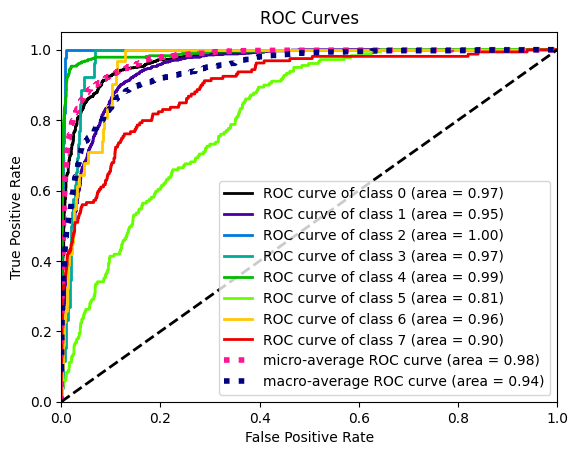

0.9442573273590724


In [710]:
plot_roc(y_val, clf.predict_proba(X_val_tr))
plt.show()
print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

verifica overfitting

Performance sul Training set:
Accuracy: 0.8039
F1 Score: 0.7936

Performance sul Validation set:
Accuracy: 0.8137
F1 Score: 0.8015


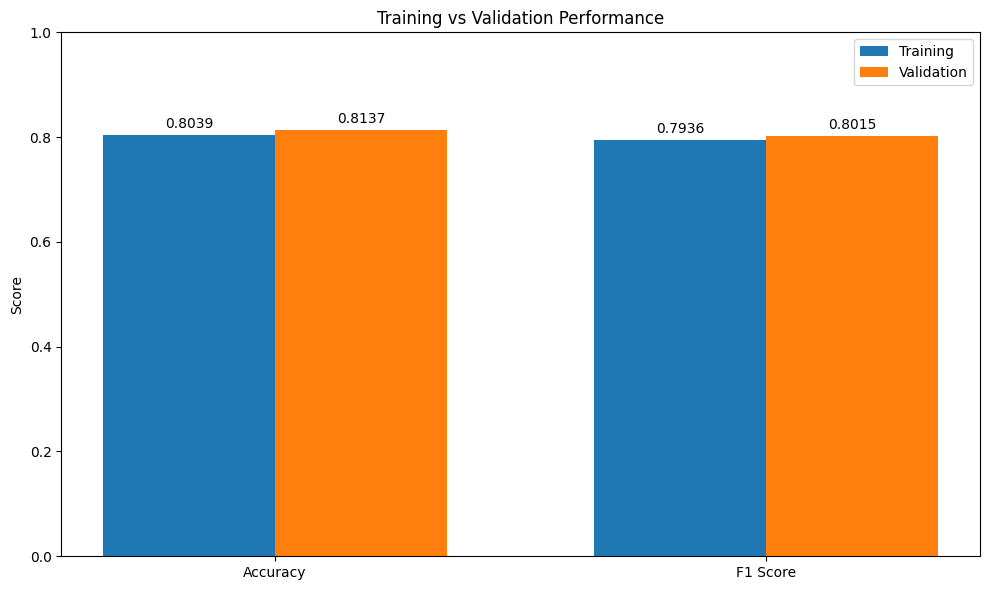

In [711]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#### Distribuzioni classi nel train set
- classi con < support sono quelle con performance peggiori
- calitare se togliere classi (togliendo 7,8,9 migliora molto)

In [712]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    3738
1    4370
2    1069
3     160
4    1912
5     665
6     127
7     585
Name: count, dtype: int64


confusion matrix 

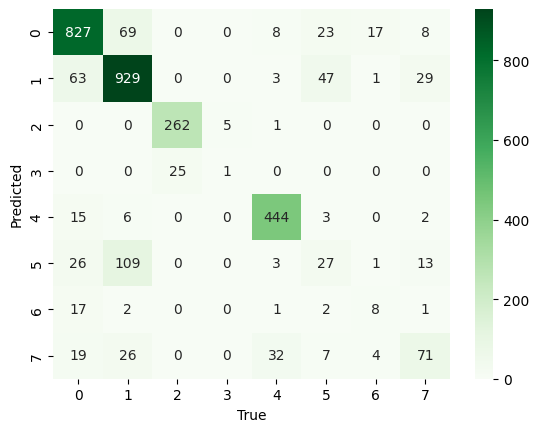

In [713]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# Proper testing on the test set

In [714]:
#clf = GaussianNB()
clf = CategoricalNB()
clf.fit(X_train_tr, y_train)
y_pred = clf.predict(X_test_tr)
y_pred
# era y_tpred

array([4, 1, 0, ..., 1, 2, 2], dtype=int64)

In [715]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_test))  

5246
5246


Performance sul Training set:
Accuracy: 0.8042
F1 Score: 0.7936

Performance sul test set:
Accuracy: 0.7991
F1 Score: 0.7876


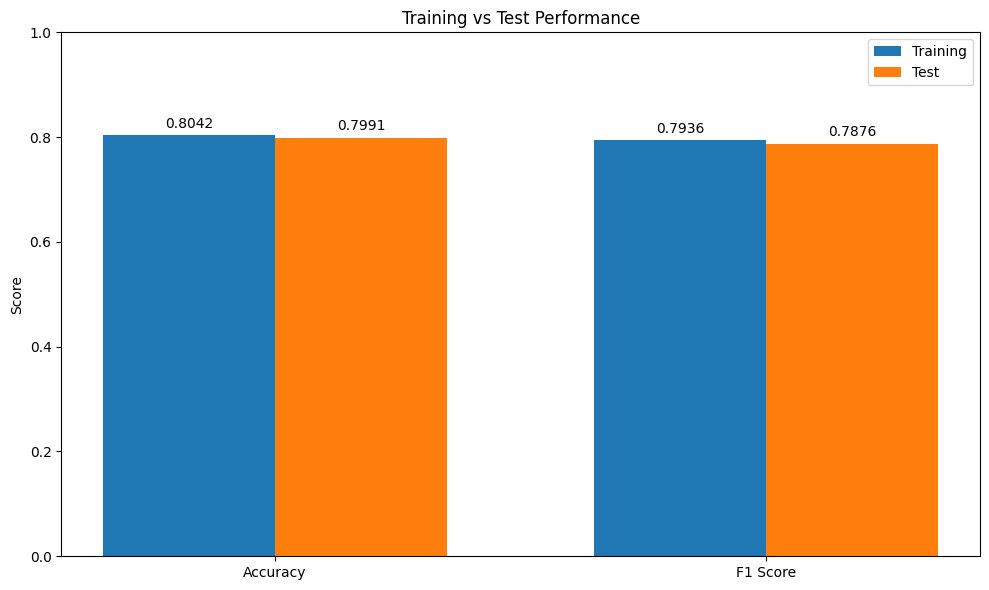

In [716]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_tr)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_tr)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
                        ### gaia ha messo y_tpred

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul test set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [717]:
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.7990850171559283

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1596
           1       0.82      0.85      0.83      1848
           2       0.87      0.96      0.91       437
           3       0.25      0.09      0.13        68
           4       0.89      0.95      0.92       728
           5       0.28      0.14      0.18       288
           6       0.14      0.19      0.16        42
           7       0.41      0.41      0.41       239

    accuracy                           0.80      5246
   macro avg       0.56      0.55      0.55      5246
weighted avg       0.78      0.80      0.79      5246



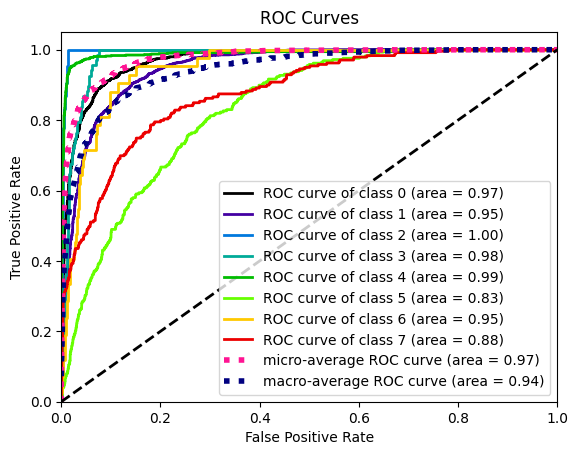

In [718]:
y_test_pred_proba = clf.predict_proba(X_test_tr)
# plot_roc(y_test, y_test_pred_proba)
# plt.show()

import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_test_pred_proba)
plt.show()

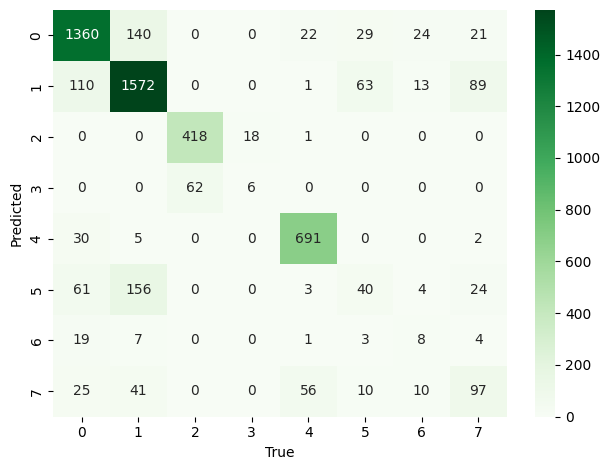

In [719]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

#### devo cambiare qualcosa?
Compare the results with a dummy classifier 

In [720]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tr, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_tr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.3522683949675944
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1596
           1       0.35      1.00      0.52      1848
           2       0.00      0.00      0.00       437
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00       728
           5       0.00      0.00      0.00       288
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00       239

    accuracy                           0.35      5246
   macro avg       0.04      0.12      0.07      5246
weighted avg       0.12      0.35      0.18      5246



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
